## Soil moisture evolution Schwarzwald (2015- 2022)

1. Map of the Harz Region 
2. Selections of Grid cells for the precipitation, radiation, tempertature and LAI data
3. Running the simple water balance model for the years 2015 to 2022 for the Harz region
4. Make a soil moisture evolution diagramm

### Importing packages 

In [99]:
import folium
import os
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import shutil
import pandas as pd
import math
import geopandas as gpd
from shapely.geometry import box
import final_model as wb
import xarray as xr
import run


### Map of the Harz region and selection of grid cells

In [55]:
file_path = "data/Harz_Aussengrenze/Harz_Aussengrenze.shp"

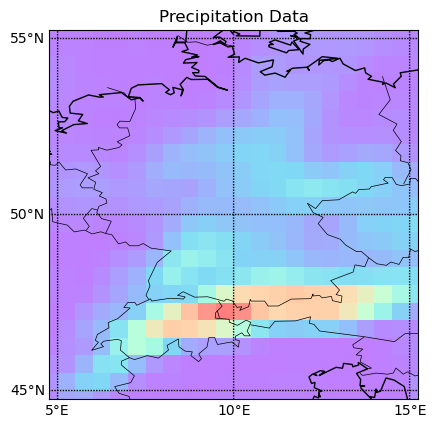

In [56]:
# File paths
precipitation_file = "data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.2000.nc"

# Open the NetCDF file
nc_file = nc.Dataset(precipitation_file)
lon = nc_file.variables['lon'][:]
lat = nc_file.variables['lat'][:]
data = nc_file.variables['tp'][50, :, :]  # Using arbitrary time index 50

# Create Basemap instance
m = Basemap(llcrnrlon=lon.min(), llcrnrlat=lat.min(),
            urcrnrlon=lon.max(), urcrnrlat=lat.max(),
            projection='cyl', resolution='l')

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Plot the precipitation data as grid cells
x_mesh, y_mesh = np.meshgrid(lon, lat)
x_mesh, y_mesh = m(x_mesh, y_mesh)
plt.pcolormesh(x_mesh, y_mesh, data, cmap='rainbow', alpha=0.5, label='Precipitation Data')

# Add latitude and longitude lines with labels
m.drawparallels(np.arange(-90., 91., 5.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0,0,0,1], fontsize=10)

plt.title('Precipitation Data')

# Show the plot
plt.show()

# Close the NetCDF file
nc_file.close()

### Harz

In [57]:
# File path to the Harz shapefile
shapefile_path = "data/harz/harz.gpkg"

# Load the shapefile using geopandas
harz_shape = gpd.read_file(shapefile_path, encoding='latin1')

# Create a Folium map
m = folium.Map()

# Add the shapefile to the map
folium.GeoJson(harz_shape).add_to(m)

# Display the map
m

In [39]:

# File path to the Schwarzwald shapefile
shapefile_path = "data/harz/harz.gpkg"

# Load the shapefile using geopandas
schwarzwald_shape = gpd.read_file(shapefile_path, encoding='latin1')

# Convert the bounds to degrees (latitude and longitude)
bounds_deg = schwarzwald_shape.total_bounds

# Print the minimum and maximum longitude and latitude values in degrees
print("Minimum Longitude:", bounds_deg[0])
print("Maximum Longitude:", bounds_deg[2])
print("Minimum Latitude:", bounds_deg[1])
print("Maximum Latitude:", bounds_deg[3])

Minimum Longitude: 10.187847835821112
Maximum Longitude: 11.449591518641023
Minimum Latitude: 51.47277216445992
Maximum Latitude: 51.94958458098154


### Reading data

In [61]:
years = np.arange(2015,2023,1)

R_data = []
T_data = []
P_data = []
lai_data = []

file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.2000.nc' # no need to change

nc_file = nc.Dataset(file_path)
lon = nc_file.variables['lon'][:]
lat = nc_file.variables['lat'][:]
nc_file.close()

In [62]:
lon_grid, lat_grid = np.meshgrid(lon, lat)
min_lon, min_lat, max_lon, max_lat = bounds_deg

In [64]:
# Find indices of lon and lat within the specified bounds
lon_idx = np.where((lon >= min_lon) & (lon <= max_lon))[0]
lat_idx = np.where((lat >= min_lat) & (lat <= max_lat))[0]

# Resulting indices
intersecting_lons = lon[lon_idx]
intersecting_lats = lat[lat_idx]

print("Longitude Indices:", lon_idx)
print("Latitude Indices:", lat_idx)
print("Intersecting Longitudes:", intersecting_lons)
print("Intersecting Latitudes:", intersecting_lats)

Longitude Indices: [11 12 13]
Latitude Indices: [7]
Intersecting Longitudes: [10.25 10.75 11.25]
Intersecting Latitudes: [51.75]


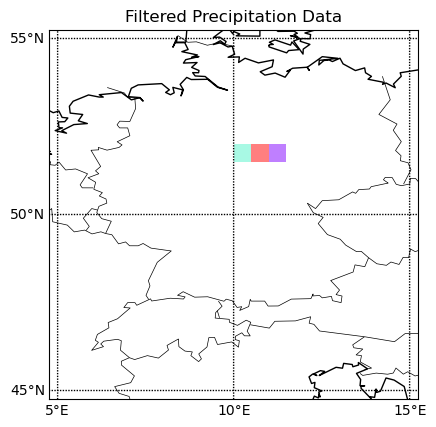

In [73]:

# File paths
precipitation_file = "data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.2000.nc"

# Open the NetCDF file
nc_file = nc.Dataset(precipitation_file)
lon = nc_file.variables['lon'][:]
lat = nc_file.variables['lat'][:]
data = nc_file.variables['tp'][50, :, :]  # Using arbitrary time index 50


# Mask data outside the polygon extent
lon_mask = (lon >= min_lon) & (lon <= max_lon)
lat_mask = (lat >= min_lat) & (lat <= max_lat)
data_masked = np.ma.masked_where(~np.outer(lat_mask, lon_mask), data)

# Create Basemap instance
m = Basemap(llcrnrlon=lon.min(), llcrnrlat=lat.min(),
            urcrnrlon=lon.max(), urcrnrlat=lat.max(),
            projection='cyl', resolution='l')

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Plot the filtered precipitation data as grid cells
x_mesh, y_mesh = np.meshgrid(lon, lat)
x_mesh, y_mesh = m(x_mesh, y_mesh)
plt.pcolormesh(x_mesh, y_mesh, data_masked, cmap='rainbow', alpha=0.5, label='Precipitation Data')

# Add latitude and longitude lines with labels
m.drawparallels(np.arange(-90., 91., 5.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0,0,0,1], fontsize=10)

plt.title('Filtered Precipitation Data')

# Show the plot
plt.show()

# Close the NetCDF file
nc_file.close()


In [101]:
years = np.arange(2015,2023,1)

R_data = []
T_data = []
P_data = []
lai_data = []

# lon_idx lat_idx


for year in years:   
        file_path1 = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.'+str(year)+'.nc'
        nc_file = nc.Dataset(file_path1)
        # 7,8 is the grid cell of interest for the respective catchment area
        dates = nc_file.variables['time'][:]
        P_data.append(nc_file.variables['tp'][:,lat_idx,lon_idx])
        nc_file.close()
        file_path1 = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.'+str(year)+'.nc'
        nc_file = nc.Dataset(file_path1)
        #print(nc_file)
        R_data.append(nc_file.variables['nr'][:,lat_idx,lon_idx])
        nc_file.close()
        file_path1 = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.'+str(year)+'.nc'
        nc_file = nc.Dataset(file_path1)
        T_data.append(nc_file.variables['t2m'][:,lat_idx,lon_idx])
        nc_file.close()  
        file_path1 = 'data/lai/lai.daily.0d50_CentralEurope.'+str(year)+'.nc'
        nc_file = nc.Dataset(file_path1)
        lai_data.append(nc_file.variables['lai'][:,lat_idx,lon_idx])
        nc_file.close()  

# looping cellwise approach

In [115]:
# Read in forcing data
years = np.arange(2000, 2024, 1)
P_data = []
R_data = []
T_data = []
lai_data = []
calibration_time = [2000, 2010]

for year in years:
    file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    P_data.append(xr.open_dataset(file_path)['tp'][:,lat_idx,lon_idx]
)

    file_path = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    R_data.append(xr.open_dataset(file_path)['nr'][:,lat_idx,lon_idx]
)

    file_path = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    T_data.append(xr.open_dataset(file_path)['t2m'][:,lat_idx,lon_idx]
)

    file_path = 'data/lai/lai.daily.0d50_CentralEurope.' + str(year) + '.nc'
    lai_data.append(xr.open_dataset(file_path)['lai'][:,lat_idx,lon_idx]
)


In [116]:
# Convert lists to xarray datasets
P_data = xr.concat(P_data, dim='time')
R_data = xr.concat(R_data, dim='time')
T_data = xr.concat(T_data, dim='time')
lai_data = xr.concat(lai_data, dim='time')

In [117]:
# Fill LAI with zeros were Na :D (wrong)
lai_data = lai_data.fillna(0)

In [100]:
# Run model for all gridcells 1:30 min for one cell... there are 484 cells

# Paramters
cs = 420 
alpha = 8 
gamma = 0.2 
beta = 0.8
cm = 1.5 
et_weight = (0.75, 0.25)

# Create empty arrays to store the output data
snow = np.zeros_like(P_data)
soil_moisture = np.zeros_like(P_data)
evapotranspiration = np.zeros_like(P_data)

# Iteerate through gridcels
for lat in range(len(P_data.lat)):
    for lon in range(len(P_data.lon)):
        
        if np.isnan(lai_data[:, lat, lon]).any():
            print("Na found in gridcell", lat, lon)
            continue

        R_data_grid = R_data[:, lat, lon]
        P_data_grid = P_data[:, lat, lon]
        T_data_grid = T_data[:, lat, lon]
        lai_data_grid = lai_data[:, lat, lon]

        # Run Model for daily values
        daily_output = run.time_evolution(P_data_grid, R_data_grid, T_data_grid, lai_data_grid, cs, alpha,
        gamma, beta, cm, et_weight)

        snow[:, lat, lon] = daily_output['snow'].values
        soil_moisture[:, lat, lon] = daily_output['calculated_soil_moisture'].values
        evapotranspiration[:, lat, lon] = daily_output['evapotranspiration'].values
        print("one done")
        
    

one done
one done
one done


In [119]:
# Convert arrays to xarrays with corresponding latitudes and longitudes
snow_xr = xr.DataArray(snow, dims=('time', 'lat', 'lon'), coords={'time': P_data.time, 'lat': P_data.lat, 'lon': P_data.lon})
soil_moisture_xr = xr.DataArray(soil_moisture, dims=('time', 'lat', 'lon'), coords={'time': P_data.time, 'lat': P_data.lat, 'lon': P_data.lon})
evapotranspiration_xr = xr.DataArray(evapotranspiration, dims=('time', 'lat', 'lon'), coords={'time': P_data.time, 'lat': P_data.lat, 'lon': P_data.lon})

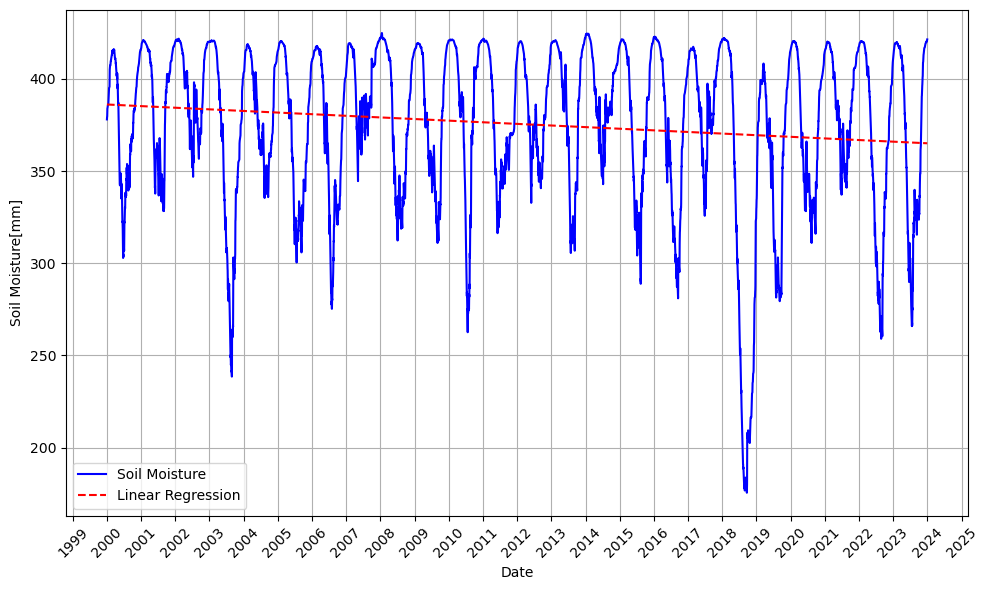

In [161]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from sklearn.linear_model import LinearRegression
import os

# Assuming soil_moisture_xr is your xarray.DataArray

# Calculate the mean along the lat and lon axes (axis=1)
mean_soil_moisture = soil_moisture_xr.mean(dim=('lat', 'lon'))

# Plot the mean soil moisture
plt.figure(figsize=(10, 6))
plt.plot(mean_soil_moisture.time, mean_soil_moisture, color='blue', linestyle='-', label='Soil Moisture')
plt.xlabel('Date')
plt.ylabel('Soil Moisture[mm]')
plt.xticks(rotation=45)

# Show every year on the x-axis
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Extracting time and soil moisture values as numpy arrays
time_values = mean_soil_moisture.time.values.astype('datetime64[D]').astype(float)  # Converting to float for LinearRegression
soil_moisture_values = mean_soil_moisture.values

# Fitting a linear regression model
model = LinearRegression()
model.fit(time_values.reshape(-1, 1), soil_moisture_values)

# Predicting values using the fitted model
predicted_values = model.predict(time_values.reshape(-1, 1))

# Plotting the linear regression line
plt.plot(mean_soil_moisture.time, predicted_values, color='red', linestyle='--', label='Linear Regression')

plt.grid(True)
plt.tight_layout()
plt.legend()

# Define the path to the results folder in your cloned GitHub repository
results_folder_path = "results"

# Check if the results folder exists, if not, create it
if not os.path.exists(results_folder_path):
    os.makedirs(results_folder_path)

# Define the filename for the exported image
image_filename = os.path.join(results_folder_path, "soil_moisture_regression_plot.pdf")

# Export the plot as vector data (PDF)
plt.savefig(image_filename, format='pdf')

# Show the plot
plt.show()
